In [ ]:
!pip install fairlearn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 15.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from fairlearn.metrics import MetricFrame, selection_rate
import matplotlib.pyplot as plt
from fairlearn.reductions import ExponentiatedGradient, DemographicParity


In [ ]:
data= pd.read_csv("/content/HeartDiseaseTrain-Test.csv")
print(data.head())

   age     sex chest_pain_type  resting_blood_pressure  cholestoral  \
0   52    Male  Typical angina                     125          212   
1   53    Male  Typical angina                     140          203   
2   70    Male  Typical angina                     145          174   
3   61    Male  Typical angina                     148          203   
4   62  Female  Typical angina                     138          294   

      fasting_blood_sugar               rest_ecg  Max_heart_rate  \
0    Lower than 120 mg/ml  ST-T wave abnormality             168   
1  Greater than 120 mg/ml                 Normal             155   
2    Lower than 120 mg/ml  ST-T wave abnormality             125   
3    Lower than 120 mg/ml  ST-T wave abnormality             161   
4  Greater than 120 mg/ml  ST-T wave abnormality             106   

  exercise_induced_angina  oldpeak        slope vessels_colored_by_flourosopy  \
0                      No      1.0  Downsloping                           Two   
1 

In [ ]:
data = data[['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholestoral', 'Max_heart_rate', 'oldpeak', 'target']]


In [ ]:
print(type(data))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
print(data.dtypes)

age                         int64
sex                        object
chest_pain_type            object
resting_blood_pressure      int64
cholestoral                 int64
Max_heart_rate              int64
oldpeak                   float64
target                      int64
dtype: object


In [ ]:
data = pd.get_dummies(data, columns=['chest_pain_type'], drop_first=True)

In [ ]:
X = data.drop('target', axis=1)
y = data['target']
sensitive_feature = X['sex']

In [ ]:
# Encode the 'sex' column before splitting
X = pd.get_dummies(X, columns=['sex'], drop_first=True)

X_train, X_test, y_train, y_test, sf_train, sf_test = train_test_split(
    X, y, sensitive_feature, test_size=0.3, random_state=42
)

In [ ]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [ ]:
#  Evaluate fairness
metric_frame = MetricFrame(
    metrics={
        "Selection Rate": selection_rate,
        "Accuracy": accuracy_score
    },
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=sf_test
)

In [ ]:
print("\nBaseline Model Metrics by Sex:")
print(metric_frame.by_group)
print("\nOverall Accuracy:", metric_frame.overall['Accuracy'])



Baseline Model Metrics by Sex:
        Selection Rate  Accuracy
sex                             
Female        0.725490  0.823529
Male          0.436893  0.752427

Overall Accuracy: 0.775974025974026


In [ ]:
fair_model = ExponentiatedGradient(
    LogisticRegression(max_iter=1000),
    constraints=DemographicParity(),
    eps=0.01
)

fair_model.fit(X_train, y_train, sensitive_features=sf_train)
y_pred_fair = fair_model.predict(X_test)


In [ ]:
# Evaluate fairness after mitigation
metric_frame_fair = MetricFrame(
    metrics={
        "Selection Rate": selection_rate,
        "Accuracy": accuracy_score
    },
    y_true=y_test,
    y_pred=y_pred_fair,
    sensitive_features=sf_test
)

print("\nFair Model Metrics by Sex:")
print(metric_frame_fair.by_group)
print("\nOverall Accuracy (Fair Model):", metric_frame_fair.overall['Accuracy'])



Fair Model Metrics by Sex:
        Selection Rate  Accuracy
sex                             
Female        0.470588  0.725490
Male          0.538835  0.728155

Overall Accuracy (Fair Model): 0.7272727272727273


In [ ]:
# 6. Visualize selection rates before & after fairness constraint

In [ ]:
before = metric_frame.by_group["Selection Rate"]
after = metric_frame_fair.by_group["Selection Rate"]

df_plot = pd.DataFrame({
    'Before Fairness': before,
    'After Fairness': after
})

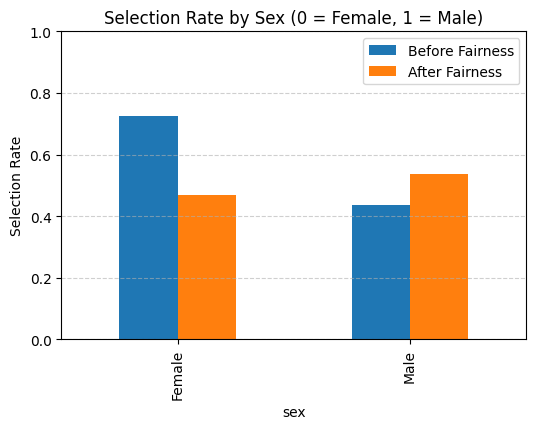

In [ ]:
df_plot.plot(kind='bar', figsize=(6,4))
plt.title("Selection Rate by Sex (0 = Female, 1 = Male)")
plt.ylabel("Selection Rate")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

```
1. Before Fairness (Blue Bars)
Female (~0.73): The model predicted a positive outcome (heart disease) for ~73% of females.

Male (~0.44): The model predicted a positive outcome for ~44% of males.
→ This is a big gap (~29%) — the model was much more likely to predict heart disease for women than for men.
```





```
2. After Fairness (Orange Bars)
Female (~0.44): The positive prediction rate for women dropped significantly.

Male (~0.54): The positive prediction rate for men increased.
→ The gap shrank to ~10%, making the model’s predictions more balanced across genders.

```





```
Before fairness: The model was biased toward predicting heart disease more often for women.

After fairness: The model’s prediction rates are closer between genders, reducing gender bias.

This comes at the cost of changing predictions, which can sometimes reduce accuracy slightly — a common trade-off in fairness interventions.
```

